In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
print(pd.__version__)

2.0.3


In [30]:
df = pd.read_csv('hyundi.csv')

df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4860 non-null   object 
 1   year          4860 non-null   int64  
 2   price         4860 non-null   int64  
 3   transmission  4860 non-null   object 
 4   mileage       4860 non-null   int64  
 5   fuelType      4860 non-null   object 
 6   tax           4860 non-null   int64  
 7   mpg           4860 non-null   float64
 8   engineSize    4860 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 341.8+ KB


**Data Cleaning**

In [32]:
# function to print the boxplots of every variable in the dataframe to see variables with possible outliers
def plot_boxplots(df):
    fig, ax = plt.subplots(figsize=(20,10))
    df.boxplot(ax=ax)
    ax.set_xticklabels(df.columns, rotation=90)
    plt.title("Boxplots of Variables")
    plt.show()

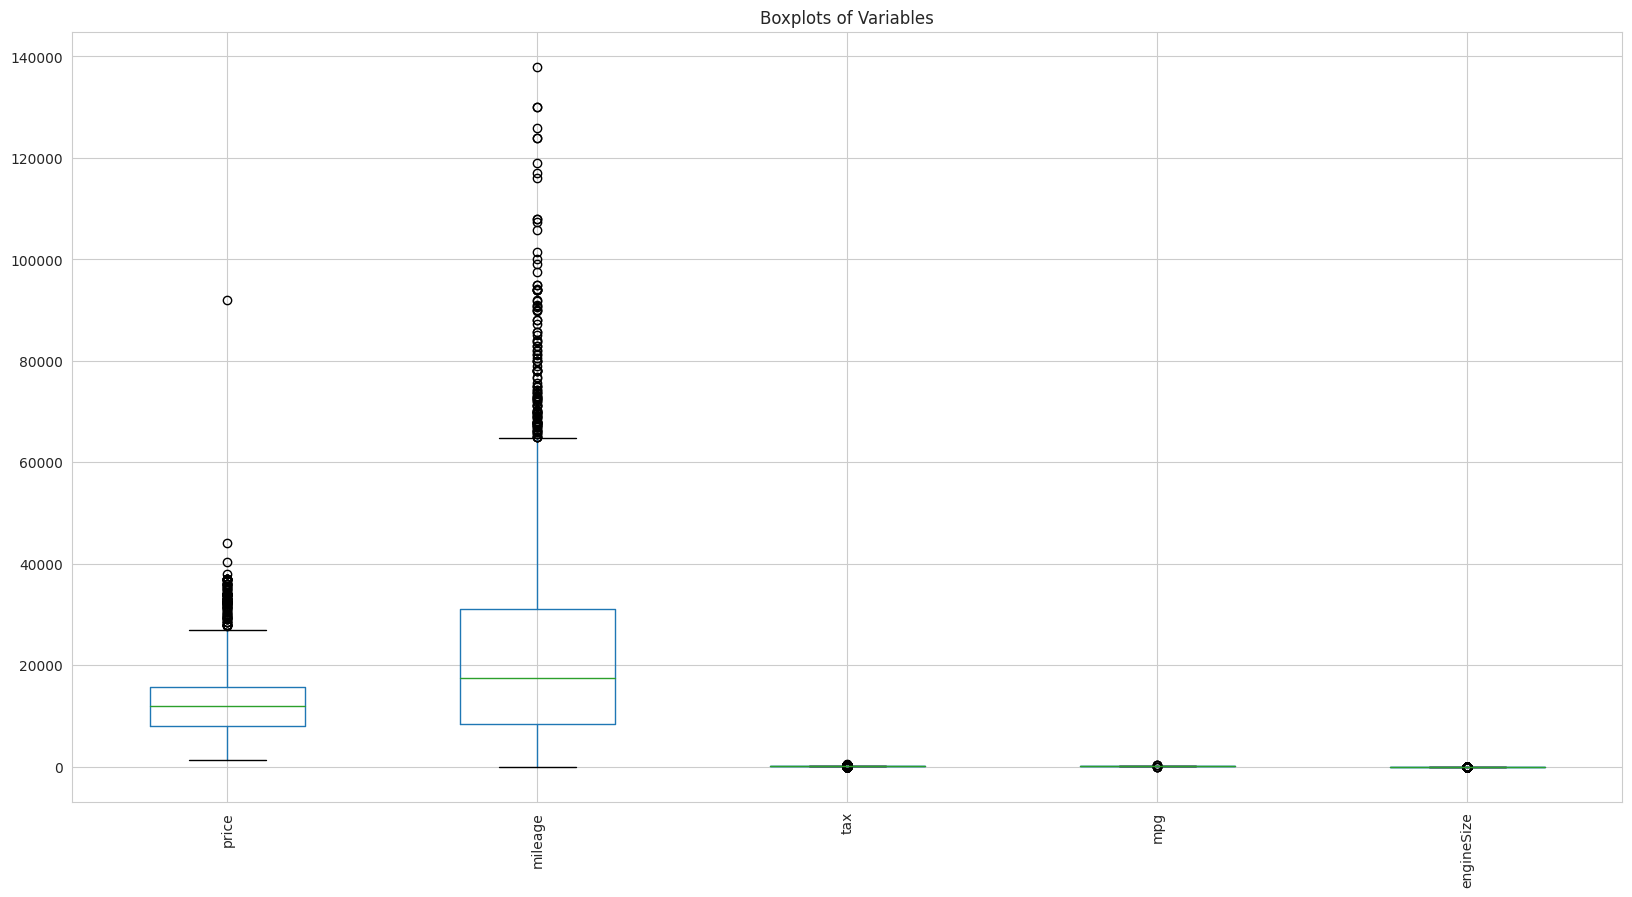

In [33]:
plot_boxplots(df[['price','mileage','tax','mpg','engineSize']])

There is no apparent outlier in the dataset

In [34]:
(df.isnull().sum()/len(df))*100 # this returns the percentage of missing data for each variable

model           0.0
year            0.0
price           0.0
transmission    0.0
mileage         0.0
fuelType        0.0
tax             0.0
mpg             0.0
engineSize      0.0
dtype: float64

In [35]:
# Check for duplicate rows in the DataFrame
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()

# Print the number of duplicate rows
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 86


There are 86 duplicate rows in the data set. The duplicates will be removed.

In [36]:
df = df.drop_duplicates()

In [37]:
# Check for duplicate rows in the DataFrame
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()

# Print the number of duplicate rows
print("Number of duplicate rows:", num_duplicate_rows)

Number of duplicate rows: 0


The duplicates are gone

**Feature Engineering**

In [38]:
import datetime

# Current year to calculate the car age
current_year = datetime.datetime.now().year

# Create new features
df['car_age'] = current_year - df['year']
df['mileage_per_year'] = df['mileage'] / df['car_age']

# Categorize engine size into bins
df['engine_size_category'] = pd.cut(df['engineSize'], bins=[0, 1.4, 2.0, 3.0], 
                                      labels=['Small', 'Medium', 'Large'])

# Calculate fuel efficiency per engine size
df['fuel_efficiency_per_engine_size'] = df['mpg'] / df['engineSize']

# Replace inf values with NaN
df['fuel_efficiency_per_engine_size'].replace([np.inf, -np.inf], np.nan, inplace=True)

# fill NaN values with the mean or median
df['fuel_efficiency_per_engine_size'].fillna(df['fuel_efficiency_per_engine_size'].median(), inplace=True)

df.head()


,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,car_age,mileage_per_year,engine_size_category,fuel_efficiency_per_engine_size
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2,7,2472.428571,Small,49.083333
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0,8,3154.125000,Medium,21.750000
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7,8,4734.625000,Medium,36.294118
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0,8,2973.625000,Small,60.100000
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0,9,3686.333333,Medium,25.700000


In [39]:
(df.isnull().sum()/len(df))*100 

model                              0.000000
year                               0.000000
price                              0.000000
transmission                       0.000000
mileage                            0.000000
fuelType                           0.000000
tax                                0.000000
mpg                                0.000000
engineSize                         0.000000
car_age                            0.000000
mileage_per_year                   0.000000
engine_size_category               0.984499
fuel_efficiency_per_engine_size    0.000000
dtype: float64

In [40]:
df.drop(['engine_size_category'],inplace=True, axis=1)

In [41]:
pip install feature_engine

Note: you may need to restart the kernel to use updated packages.


In [42]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [43]:
from feature_engine.encoding import OneHotEncoder

def encode_categorical_variables(df):
    # List the categorical and bool columns
    categorical_columns = list(df.select_dtypes(include=['object','category']).columns)
    
    # Create the one-hot encoder instance
    encoder = OneHotEncoder(variables=categorical_columns, drop_last=False)  # drop_last=False keeps all categories
    
    # Fit and transform the data
    df_encoded = encoder.fit_transform(df)
    
    return df_encoded

In [44]:
df = encode_categorical_variables(df)

df.head()

,year,price,mileage,tax,mpg,engineSize,car_age,mileage_per_year,fuel_efficiency_per_engine_size,model_ I20,model_ Tucson,model_ I10,model_ IX35,model_ I30,model_ I40,model_ Ioniq,model_ Kona,model_ Veloster,model_ I800,model_ IX20,model_ Santa Fe,model_ Accent,model_ Terracan,model_ Getz,model_ Amica,transmission_Manual,transmission_Automatic,transmission_Semi-Auto,transmission_Other,fuelType_Petrol,fuelType_Diesel,fuelType_Hybrid,fuelType_Other
0,2017,7999,17307,145,58.9,1.2,7,2472.428571,49.083333,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,2016,14499,25233,235,43.5,2.0,8,3154.125000,21.750000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2016,11399,37877,30,61.7,1.7,8,4734.625000,36.294118,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
3,2016,6499,23789,20,60.1,1.0,8,2973.625000,60.100000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,2015,10199,33177,160,51.4,2.0,9,3686.333333,25.700000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0


In [45]:
(df.isnull().sum()/len(df))*100 

year                               0.0
price                              0.0
mileage                            0.0
tax                                0.0
mpg                                0.0
engineSize                         0.0
car_age                            0.0
mileage_per_year                   0.0
fuel_efficiency_per_engine_size    0.0
model_ I20                         0.0
model_ Tucson                      0.0
model_ I10                         0.0
model_ IX35                        0.0
model_ I30                         0.0
model_ I40                         0.0
model_ Ioniq                       0.0
model_ Kona                        0.0
model_ Veloster                    0.0
model_ I800                        0.0
model_ IX20                        0.0
model_ Santa Fe                    0.0
model_ Accent                      0.0
model_ Terracan                    0.0
model_ Getz                        0.0
model_ Amica                       0.0
transmission_Manual      

In [46]:
df.columns = df.columns.str.replace(' ', '_')


**Model Training**

In [47]:
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,cross_validate
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import make_scorer, mean_absolute_error,mean_squared_error,r2_score

def evaluate_models(X_train, X_test, y_train, y_test):
    
    
    lgb_model = LGBMRegressor(objective='regression',metric='mse',n_jobs=-1,random_state=101)
    rf_model = RandomForestRegressor(n_jobs=-1,criterion='squared_error',random_state=101)
    
    

    
    # Fit models on the train dataset
    lgb_model.fit(X_train,y_train)
    rf_model.fit(X_train,y_train)
    

    # Make predictions on the test dataset
    y_pred_lgb = lgb_model.predict(X_test)
    y_pred_rf = rf_model.predict(X_test)

    # Evaluate models with test data using MAE, MSE, RMSE, and R2 and save to dataframe
    eval_test_data = pd.DataFrame({
        'Metric': ['MAE', 'MSE', 'RMSE', 'R2'],
        'LightGBM': [mean_absolute_error(y_test, y_pred_lgb), 
                     mean_squared_error(y_test, y_pred_lgb), 
                     np.sqrt(mean_squared_error(y_test, y_pred_lgb)), 
                     r2_score(y_test, y_pred_lgb)],
        'Random Forest': [mean_absolute_error(y_test, y_pred_rf), 
                     mean_squared_error(y_test, y_pred_rf), 
                     np.sqrt(mean_squared_error(y_test, y_pred_rf)), 
                     r2_score(y_test, y_pred_rf)]
    })

    return eval_test_data

X = df.drop(columns=['price'])
y = df['price']
    # create the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

eval_test_data = evaluate_models(X_train, X_test, y_train, y_test)

In [48]:
eval_test_data

,Metric,LightGBM,Random Forest
0,MAE,8.243682e+02,8.744855e+02
1,MSE,1.410314e+06,2.171622e+06
2,RMSE,1.187567e+03,1.473642e+03
3,R2,9.531218e-01,9.278162e-01


Lightgbm performed better. It will be optimized using FLAML

In [49]:
pip install flaml[automl]

Note: you may need to restart the kernel to use updated packages.


In [50]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [52]:
from flaml import AutoML
def tune_lightgbm(X, y):
    
    # define the X and y variables
    X = df.drop(columns=['price'])
    y = df['price']
    # create the train and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=287)
    
    # define the optimization function
    lgb_tune = AutoML()
    

    # define the setting for optimization
    
    settings = {
    "time_budget": 1200,  # total running time in seconds
    "metric": 'mse',  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "estimator_list": ['lgbm'],  # list of ML learners; we tune random forest in this experiment
    "task": 'regression' # task type  

}

    
    
    
    # run flaml optimization to find the best hyperparameters for the random forest
    lgb_tune.fit(X_train, y_train,**settings,n_jobs=-1,early_stop=True,hpo_method='bs',eval_method='cv',n_splits=5)
    
    # return the best hyperparameters and the best score
    return lgb_tune.best_config

best_config = tune_lightgbm(df.drop(columns=['price']), df['price'])

[flaml.automl.logger: 10-17 06:03:19] {1728} INFO - task = regression
[flaml.automl.logger: 10-17 06:03:19] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 10-17 06:03:19] {1838} INFO - Minimizing error metric: mse
[flaml.automl.logger: 10-17 06:03:19] {1955} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 10-17 06:03:19] {2258} INFO - iteration 0, current learner lgbm


2024-10-17 06:03:19,660	WARNING optuna_search.py:334 -- You passed a `space` parameter to OptunaSearch that contained unresolved search space definitions. OptunaSearch should however be instantiated with fully configured search spaces only. To use Ray Tune's automatic search space conversion, pass the space definition as part of the `param_space` argument to `tune.Tuner()` instead.
[I 2024-10-17 06:03:19,662] A new study created in memory with name: optuna


[flaml.automl.logger: 10-17 06:03:19] {2393} INFO - Estimated sufficient time budget=922s. Estimated necessary time budget=1s.
[flaml.automl.logger: 10-17 06:03:19] {2442} INFO -  at 0.1s,	estimator lgbm's best error=23783141.8333,	best estimator lgbm's best error=23783141.8333
[flaml.automl.logger: 10-17 06:03:19] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-17 06:03:19] {2442} INFO -  at 0.3s,	estimator lgbm's best error=23783141.8333,	best estimator lgbm's best error=23783141.8333
[flaml.automl.logger: 10-17 06:03:19] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 10-17 06:03:19] {2442} INFO -  at 0.4s,	estimator lgbm's best error=12898427.9762,	best estimator lgbm's best error=12898427.9762
[flaml.automl.logger: 10-17 06:03:19] {2258} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 10-17 06:03:20] {2442} INFO -  at 0.5s,	estimator lgbm's best error=5442667.4611,	best estimator lgbm's best error=5442667.4611
[flaml.au

In [53]:
best_config

{'n_estimators': 292,
 'num_leaves': 44,
 'min_child_samples': 13,
 'learning_rate': 0.018229428163005504,
 'log_max_bin': 9,
 'colsample_bytree': 0.353714329942247,
 'reg_alpha': 0.0009765625,
 'reg_lambda': 0.0009765625}

In [54]:
X = df.drop(columns=['price'])
y = df['price']
    # create the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=101)

In [55]:
from lightgbm import LGBMRegressor

# Add the new hyperparameters
lgb_model = LGBMRegressor(
    objective='regression',
    metric='mse',
    n_jobs=-1,
    random_state=101,
    n_estimators=292,
    num_leaves=44,
    min_child_samples=13,
    learning_rate=0.018229428163005504,
    max_bin=2**9,  # Since `log_max_bin` is 9, max_bin is 2^9 = 512
    colsample_bytree=0.353714329942247,
    reg_alpha=0.0009765625,
    reg_lambda=0.0009765625
)

lgb_model.fit(X_train, y_train)


LGBMRegressor(colsample_bytree=0.353714329942247,
              learning_rate=0.018229428163005504, max_bin=512, metric='mse',
              min_child_samples=13, n_estimators=292, n_jobs=-1, num_leaves=44,
              objective='regression', random_state=101, reg_alpha=0.0009765625,
              reg_lambda=0.0009765625)

In [56]:
pred = lgb_model.predict(X_test)

In [57]:
print('MAE:', mean_absolute_error(y_test, pred))
print('MSE:', mean_squared_error(y_test, pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test, pred)))
print('R-squared: ',r2_score(y_test,pred))

MAE: 791.0700344899118
MSE: 1293858.936212952
RMSE: 1137.479202540843
R-squared:  0.956992694337279


The hyperparameter tuning improved the model accuracy

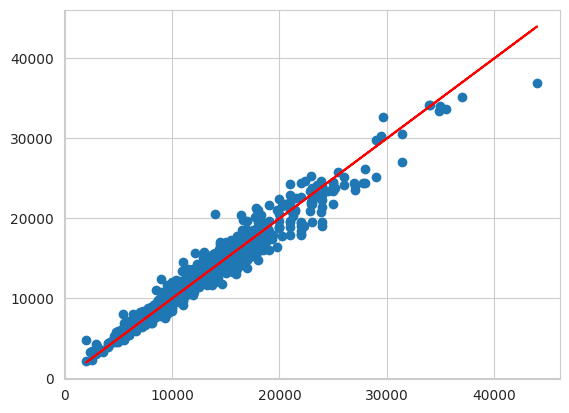

In [58]:
# Our predictions
plt.scatter(y_test,pred)

# Perfect predictions
plt.plot(y_test,y_test,'r')

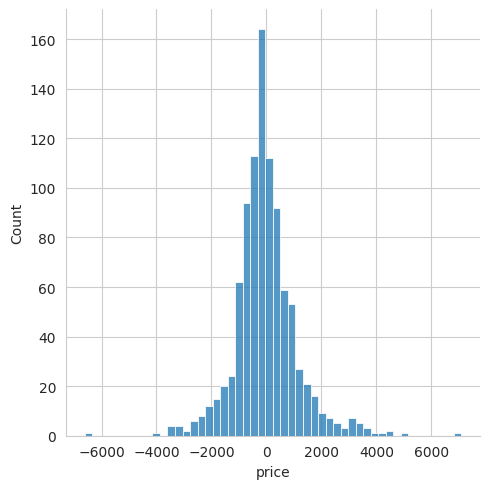

In [59]:
sns.displot((y_test-pred),bins=50) # plot a residual histogram by passing the y_test-predictions

In [ ]:
import joblib

# Save the model as a pickle in a file
filename = 'car_price_predictor.pkl'
joblib.dump(lgb_model, filename)

In [ ]:
import sklearn
print(sklearn.__version__)


In [ ]:
(base) jupyter@vm-c0dd66e7-01a6-4ac3-be31-b2e9a042225f:~/Car-Prediction-2$ python --version
Python 3.10.15
(base) jupyter@vm-c0dd66e7-01a6-4ac3-be31-b2e9a042225f:~/Car-Prediction-2$ pip show cloudpickle
Name: cloudpickle
Version: 3.0.0
Summary: Pickler class to extend the standard pickle.Pickler functionality
Home-page: https://github.com/cloudpipe/cloudpickle
Author: The cloudpickle developer team
Author-email: cloudpipe@googlegroups.com
License: BSD-3-Clause
Location: /opt/conda/lib/python3.10/site-packages
Requires: 
Required-by: bigframes, gymnasium

In [60]:
import lightgbm as lgb
print(lgb.__version__)

4.5.0
